In [1]:
!pip install snowflake-snowpark-python
!pip install "snowflake-snowpark-python[pandas]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.7/419.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 9.6 MB/s eta 0:00:00


In [5]:
from snowflake.snowpark import Session
import numpy as np
import pandas as pd
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import year, month,avg
from snowflake.snowpark.functions import count, col, when,lit
from snowflake.snowpark.functions import min as sp_min, count, sum as sp_sum

from snowflake.snowpark.types import IntegerType, FloatType, DoubleType, DecimalType, StringType, DateType, TimestampType, LongType
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from google.colab import files
import datetime

In [6]:
parameters = {
...    "account": "YEZEPEO-DATASCIENCE",
...    "user": "VNSHARED",
...    "password": "Columbia2024!",
...    "role": "SYSADMIN", # optional
...    "warehouse": "ANALYSIS", # optional
...   "database": "MEIXI_DATA", # optional
...   "schema":"PUBLIC",  # optional
...  }
session= Session.builder.configs(parameters).create()

#Create table with individual client data: date joined, and yearly % default for each following year

# DO NOT RUN THIS AGAIN

just use the table later

In [ ]:
df_v=session.sql('select * from CONSOLIDATED_SORTED')
df_v = df_v.select("FECHAEMISION", "BUSINESSPARTNERID","STATUSCOMPENSACION","YEAR_FECHAEMISION")

In [ ]:
df_v.show(10)


-------------------------------------------------------------------------------------
|"FECHAEMISION"  |"BUSINESSPARTNERID"  |"STATUSCOMPENSACION"  |"YEAR_FECHAEMISION"  |
-------------------------------------------------------------------------------------
|2021-08-26      |0013221790           |UNPAID                |2021                 |
|2021-08-26      |0013221790           |UNPAID                |2021                 |
|2021-08-26      |0013221790           |UNPAID                |2021                 |
|2021-08-26      |0013221790           |UNPAID                |2021                 |
|2021-08-26      |0013221790           |UNPAID                |2021                 |
|2021-08-26      |0013221790           |UNPAID                |2021                 |
|2021-08-26      |0013221790           |PAID                  |2021                 |
|2021-08-26      |0013221790           |UNPAID                |2021                 |
|2021-08-26      |0013221790           |UNPAID        

In [ ]:

# Create a DataFrame for aggregated default rates
default_rates_df = df_v.group_by("BUSINESSPARTNERID", "YEAR_FECHAEMISION").agg(
    (sp_sum(when(col("STATUSCOMPENSACION") == "UNPAID", 1).otherwise(0)) / count("*") * 100).alias("DEFAULT_RATE")
)

# Find the first year each client appears
first_year_df = df_v.group_by("BUSINESSPARTNERID").agg(
    sp_min("YEAR_FECHAEMISION").alias("FIRST_YEAR")
)

# Join and pivot using correct Snowpark usage
df_v_joined = default_rates_df.join(
    first_year_df,
    "BUSINESSPARTNERID"
)

# Register as a temp view for SQL pivoting
df_v_joined.create_or_replace_temp_view("df_v_joined")

# Construct the pivot query using Snowflake SQL
# Construct the pivot query using Snowflake SQL correctly
pivot_query = """
SELECT *
FROM df_v_joined
PIVOT(
    AVG(DEFAULT_RATE) FOR YEAR_FECHAEMISION IN (2006, 2007, 2008, 2009, 2010,
                                                2011, 2012, 2013, 2014, 2015,
                                                2016, 2017, 2018, 2019, 2020,
                                                2021, 2022, 2023)
) AS p
ORDER BY BUSINESSPARTNERID

"""

pivoted_results = session.sql(pivot_query)




In [ ]:
# Step 4: Display or use the default rates data
pivoted_results.show(5)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"BUSINESSPARTNERID"  |"FIRST_YEAR"  |"2006"  |"2007"  |"2008"  |"2009"  |"2010"  |"2011"  |"2012"  |"2013"  |"2014"  |"2015"  |"2016"  |"2017"  |"2018"  |"2019"  |"2020"  |"2021"  |"2022"           |"2023"            |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0013763573           |2021          |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |0E-12   |0E-12            |0E-12             |
|0013763574           |2022          |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |N

In [ ]:
# Upload as table to Snowflake
table_name = 'USERS_INDIVIDUAL_DATES_AND_DEFAULTS'

# Write the DataFrame to a new table in Snowflake
pivoted_results.write.mode('overwrite').save_as_table(table_name)

# Use the table

In [ ]:
df_v=session.sql('select * from USERS_INDIVIDUAL_DATES_AND_DEFAULTS')

In [ ]:
df_v.show(5)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"BUSINESSPARTNERID"  |"FIRST_YEAR"  |"2006"  |"2007"  |"2008"  |"2009"  |"2010"  |"2011"  |"2012"  |"2013"  |"2014"  |"2015"  |"2016"  |"2017"  |"2018"  |"2019"  |"2020"  |"2021"           |"2022"  |"2023"           |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0013762740           |2022          |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL             |0E-12   |0E-12            |
|0013762743           |2022          |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL    |NULL 

# Aggregate yearly default rates for users grouped by their starting date and plot these groups with x-axis representing years

In [ ]:
# Manually specify the aggregation for each year
aggregated_df = df_v.group_by("FIRST_YEAR").agg(
    avg(col("2006")).alias('avg_2006'),
    avg(col("2007")).alias('avg_2007'),
    avg(col("2008")).alias('avg_2008'),
    avg(col("2009")).alias('avg_2009'),
    avg(col("2010")).alias('avg_2010'),
    avg(col("2011")).alias('avg_2011'),
    avg(col("2012")).alias('avg_2012'),
    avg(col("2013")).alias('avg_2013'),
    avg(col("2014")).alias('avg_2014'),
    avg(col("2015")).alias('avg_2015'),
    avg(col("2016")).alias('avg_2016'),
    avg(col("2017")).alias('avg_2017'),
    avg(col("2018")).alias('avg_2018'),
    avg(col("2019")).alias('avg_2019'),
    avg(col("2020")).alias('avg_2020'),
    avg(col("2021")).alias('avg_2021'),
    avg(col("2022")).alias('avg_2022'),
    avg(col("2023")).alias('avg_2023')
)

# Convert to Pandas DataFrame for plotting
pandas_df = aggregated_df.to_pandas()

# Display the DataFrame to verify
print(pandas_df.head())


   FIRST_YEAR  AVG_2006  AVG_2007  AVG_2008  AVG_2009  AVG_2010   AVG_2011  \
0        2007       NaN  5.760862  4.826286  5.529813  6.985947  13.797318   
1        2015       NaN       NaN       NaN       NaN       NaN        NaN   
2        2017       NaN       NaN       NaN       NaN       NaN        NaN   
3        2022       NaN       NaN       NaN       NaN       NaN        NaN   
4        2012       NaN       NaN       NaN       NaN       NaN        NaN   

   AVG_2012  AVG_2013   AVG_2014   AVG_2015   AVG_2016   AVG_2017   AVG_2018  \
0  9.284582  7.607714   8.468626   7.868423  10.658617  10.534399   9.373776   
1       NaN       NaN        NaN  10.159325  13.801417  12.769527  19.996981   
2       NaN       NaN        NaN        NaN        NaN  11.469216  12.079690   
3       NaN       NaN        NaN        NaN        NaN        NaN        NaN   
4  8.691095  9.591516  11.365129  18.237651  16.054301  15.229697  15.009569   

    AVG_2019   AVG_2020   AVG_2021   AVG_2022   AV

In [ ]:
pandas_df

,FIRST_YEAR,AVG_2006,AVG_2007,AVG_2008,AVG_2009,AVG_2010,AVG_2011,AVG_2012,AVG_2013,AVG_2014,AVG_2015,AVG_2016,AVG_2017,AVG_2018,AVG_2019,AVG_2020,AVG_2021,AVG_2022,AVG_2023
0,2007,NaN,5.760862,4.826286,5.529813,6.985947,13.797318,9.284582,7.607714,8.468626,7.868423,10.658617,10.534399,9.373776,10.377951,11.419328,9.810332,11.192152,16.235988
1,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.159325,13.801417,12.769527,19.996981,15.007647,16.384216,16.367442,18.278501,24.425204
2,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.469216,12.079690,14.272228,22.953289,17.579503,20.043132,26.973177
3,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.428365,22.117896
4,2012,NaN,NaN,NaN,NaN,NaN,NaN,8.691095,9.591516,11.365129,18.237651,16.054301,15.229697,15.009569,17.159733,16.425871,15.543569,17.591850,23.513104
5,2011,NaN,NaN,NaN,NaN,NaN,7.912300,7.924910,10.010526,17.598973,11.927273,14.820385,14.205185,14.647538,15.452848,15.179292,14.702201,16.578500,22.356013
6,2010,NaN,NaN,NaN,NaN,8.869038,7.973302,9.443017,19.259631,13.264254,12.367011,15.197737,15.557601,14.496377,15.600113,15.780100,15.360526,17.192732,23.282732
7,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.132518,10.329783,10.902599,19.951086,15.515215,15.153306,15.612122,17.822303,16.117039,18.483241,24.532302
8,2009,NaN,NaN,NaN,7.856493,7.558292,11.684440,13.547492,10.854079,11.965906,10.583689,14.150923,13.484310,12.524111,13.580750,14.372272,13.243536,14.849868,20.621261
9,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.924433,16.604354,26.686205


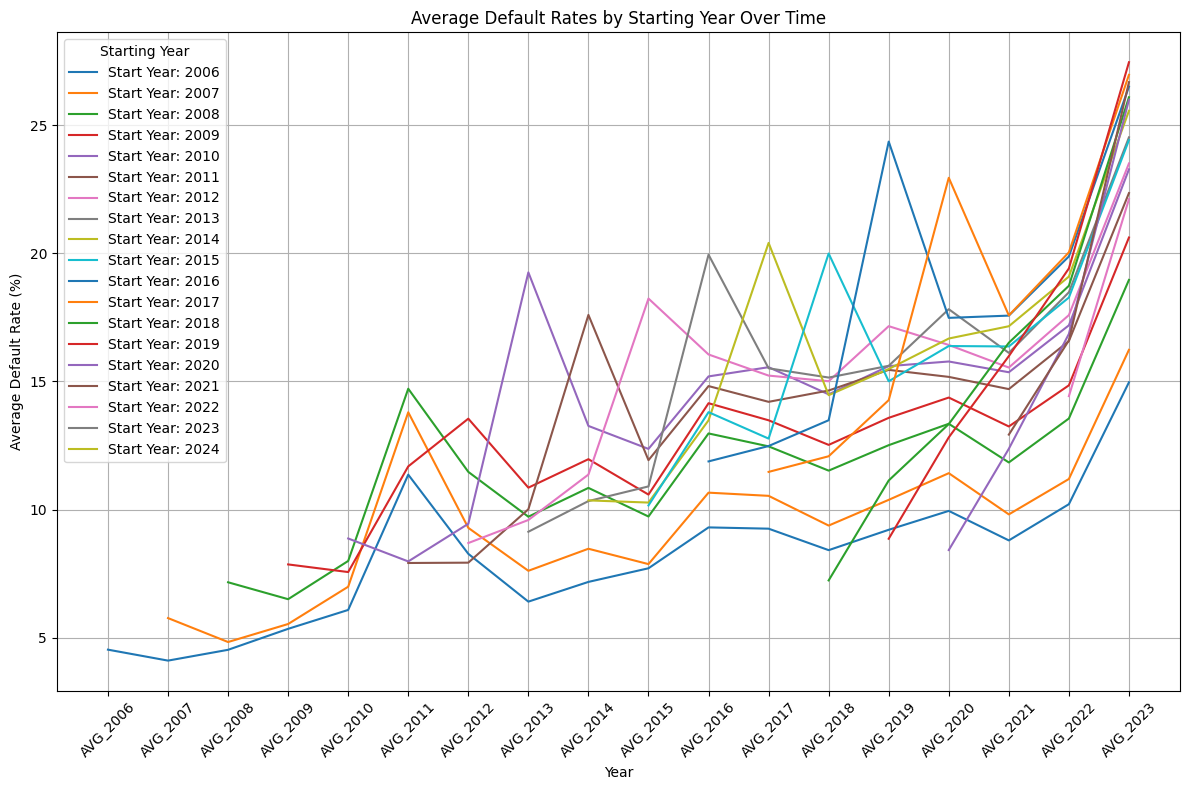

In [ ]:
import matplotlib.pyplot as plt

# Set the 'FIRST_YEAR' as the index for easier plotting
pandas_df.set_index('FIRST_YEAR', inplace=True)

# Transpose the DataFrame to make plotting along the years easier
transposed_df = pandas_df.transpose()

# Sort the columns (starting years) in ascending order
transposed_df = transposed_df.reindex(sorted(transposed_df.columns), axis=1)

# Plotting
plt.figure(figsize=(12, 8))  # Set the figure size for better visibility

# Iterate over each column in the transposed DataFrame to create a line plot for each group
for column in transposed_df.columns:
    plt.plot(transposed_df.index, transposed_df[column], label=f'Start Year: {column}')

plt.title('Average Default Rates by Starting Year Over Time')
plt.xlabel('Year')
plt.ylabel('Average Default Rate (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Starting Year', loc='upper left')  # Add a legend to distinguish the lines
plt.grid(True)  # Add grid for easier readability of the plot
plt.tight_layout()  # Adjust layout to make room for x-axis labels

plt.show()


#Create table with individual client data: date joined, and yearly transaction amount for each following year

# DO NOT RUN THIS AGAIN

just use the table later

In [ ]:
df_v=session.sql('select * from CONSOLIDATED_SORTED')
df_v = df_v.select("FECHAEMISION", "BUSINESSPARTNERID","IMPORTEPESOS","YEAR_FECHAEMISION")

In [ ]:
df_v.show(10)


-------------------------------------------------------------------------------
|"FECHAEMISION"  |"BUSINESSPARTNERID"  |"IMPORTEPESOS"  |"YEAR_FECHAEMISION"  |
-------------------------------------------------------------------------------
|2021-08-26      |0013221790           |5207.0          |2021                 |
|2021-08-26      |0013221790           |1348.0          |2021                 |
|2021-08-26      |0013221790           |24020.0         |2021                 |
|2021-08-26      |0013221790           |46.0            |2021                 |
|2021-08-26      |0013221790           |541.0           |2021                 |
|2021-08-26      |0013221790           |10071.0         |2021                 |
|2021-08-26      |0013221790           |-5.0            |2021                 |
|2021-08-26      |0013221790           |125.0           |2021                 |
|2021-08-26      |0013221790           |1407.0          |2021                 |
|2021-08-26      |0013221857           |

In [ ]:
# Create a DataFrame for aggregated transaction amounts
transaction_amounts_df = df_v.group_by("BUSINESSPARTNERID", "YEAR_FECHAEMISION").agg(
    avg(col("IMPORTEPESOS")).alias("AVG_TRANSACTION_AMOUNT")
)

# Find the first year each client appears
first_year_df = df_v.group_by("BUSINESSPARTNERID").agg(
    sp_min("YEAR_FECHAEMISION").alias("FIRST_YEAR")
)

# Join aggregated transaction data with the first year data
df_v_joined = transaction_amounts_df.join(
    first_year_df,
    "BUSINESSPARTNERID"
)

# Register as a temp view for SQL pivoting
df_v_joined.create_or_replace_temp_view("df_v_joined")

# Construct the pivot query using Snowflake SQL
pivot_query = """
SELECT *
FROM df_v_joined
PIVOT(
    AVG(AVG_TRANSACTION_AMOUNT) FOR YEAR_FECHAEMISION IN (2006, 2007, 2008, 2009, 2010,
                                                         2011, 2012, 2013, 2014, 2015,
                                                         2016, 2017, 2018, 2019, 2020,
                                                         2021, 2022, 2023)
) AS p
ORDER BY BUSINESSPARTNERID
"""

pivoted_results = session.sql(pivot_query)




In [ ]:
# Upload as table to Snowflake
table_name = 'USERS_INDIVIDUAL_DATES_AND_TRANSACTION_AMOUNTS'
pivoted_results.write.mode('overwrite').save_as_table(table_name)

# Use table instead

In [ ]:
# Load the data from Snowflake into a DataFrame
df_v = session.table('USERS_INDIVIDUAL_DATES_AND_TRANSACTION_AMOUNTS').to_pandas()

In [ ]:
# Group by 'FIRST_YEAR' to aggregate the average transaction amounts
aggregated_df = df_v.groupby("FIRST_YEAR").mean()

# Transpose the DataFrame to make plotting along the years easier
transposed_df = aggregated_df.transpose()

# Sort the columns (starting years) in ascending order
transposed_df = transposed_df.reindex(sorted(transposed_df.columns), axis=1)

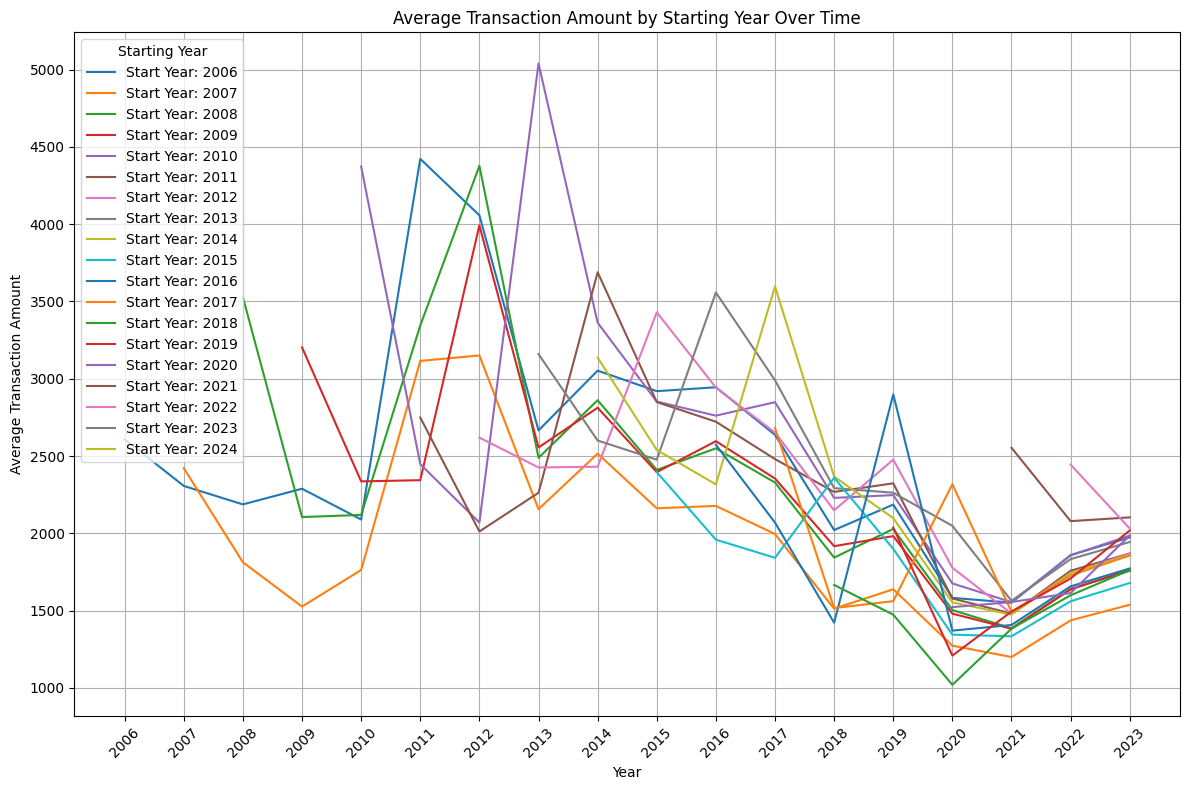

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))  # Set the figure size for better visibility

# Iterate over each column in the transposed DataFrame to create a line plot for each group
for column in transposed_df.columns:
    plt.plot(transposed_df.index, transposed_df[column], label=f'Start Year: {column}')

plt.title('Average Transaction Amount by Starting Year Over Time')
plt.xlabel('Year')
plt.ylabel('Average Transaction Amount')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Starting Year', loc='upper left')  # Add a legend to distinguish the lines
plt.grid(True)  # Add grid for easier readability of the plot
plt.tight_layout()  # Adjust layout to make room for x-axis labels

plt.show()

#Create table with individual client data: date joined, and number of vehichles

# DO NOT RUN THIS AGAIN

just use the table later

In [ ]:
df_v=session.sql('select * from CONSOLIDATED_SORTED')
df_v = df_v.select("FECHAEMISION", "BUSINESSPARTNERID","CANTIDADVEHICULOS","YEAR_FECHAEMISION")

In [ ]:
df_v.show(10)

------------------------------------------------------------------------------------
|"FECHAEMISION"  |"BUSINESSPARTNERID"  |"CANTIDADVEHICULOS"  |"YEAR_FECHAEMISION"  |
------------------------------------------------------------------------------------
|2021-08-26      |0013221790           |2                    |2021                 |
|2021-08-26      |0013221790           |2                    |2021                 |
|2021-08-26      |0013221790           |2                    |2021                 |
|2021-08-26      |0013221790           |2                    |2021                 |
|2021-08-26      |0013221790           |2                    |2021                 |
|2021-08-26      |0013221790           |2                    |2021                 |
|2021-08-26      |0013221790           |2                    |2021                 |
|2021-08-26      |0013221790           |2                    |2021                 |
|2021-08-26      |0013221790           |2                    |202

In [ ]:
# Create a DataFrame for aggregated number of vehicles
vehicle_counts_df = df_v.group_by("BUSINESSPARTNERID", "YEAR_FECHAEMISION").agg(
    avg(col("CANTIDADVEHICULOS")).alias("AVG_VEHICLES")
)

# Find the first year each client appears
first_year_df = df_v.group_by("BUSINESSPARTNERID").agg(
    sp_min("YEAR_FECHAEMISION").alias("FIRST_YEAR")
)

# Join aggregated vehicle data with the first year data
df_v_joined = vehicle_counts_df.join(
    first_year_df,
    "BUSINESSPARTNERID"
)

# Register as a temp view for SQL pivoting
df_v_joined.create_or_replace_temp_view("df_v_joined")

# Construct the pivot query using Snowflake SQL
pivot_query = """
SELECT *
FROM df_v_joined
PIVOT(
    AVG(AVG_VEHICLES) FOR YEAR_FECHAEMISION IN (2006, 2007, 2008, 2009, 2010,
                                                2011, 2012, 2013, 2014, 2015,
                                                2016, 2017, 2018, 2019, 2020,
                                                2021, 2022, 2023)
) AS p
ORDER BY BUSINESSPARTNERID
"""

pivoted_results = session.sql(pivot_query)


In [ ]:
# Upload as table to Snowflake
table_name = 'USERS_INDIVIDUAL_DATES_AND_VEHICLES_OVER_YEARS'
pivoted_results.write.mode('overwrite').save_as_table(table_name)


# Use table instead

In [ ]:
df_v = session.table('USERS_INDIVIDUAL_DATES_AND_VEHICLES_OVER_YEARS').to_pandas()

In [ ]:
# Group by 'FIRST_YEAR' to aggregate the average number of vehicles
aggregated_df = df_v.groupby("FIRST_YEAR").mean()

# Transpose the DataFrame to make plotting along the years easier
transposed_df = aggregated_df.transpose()

# Sort the columns (starting years) in ascending order
transposed_df = transposed_df.reindex(sorted(transposed_df.columns), axis=1)


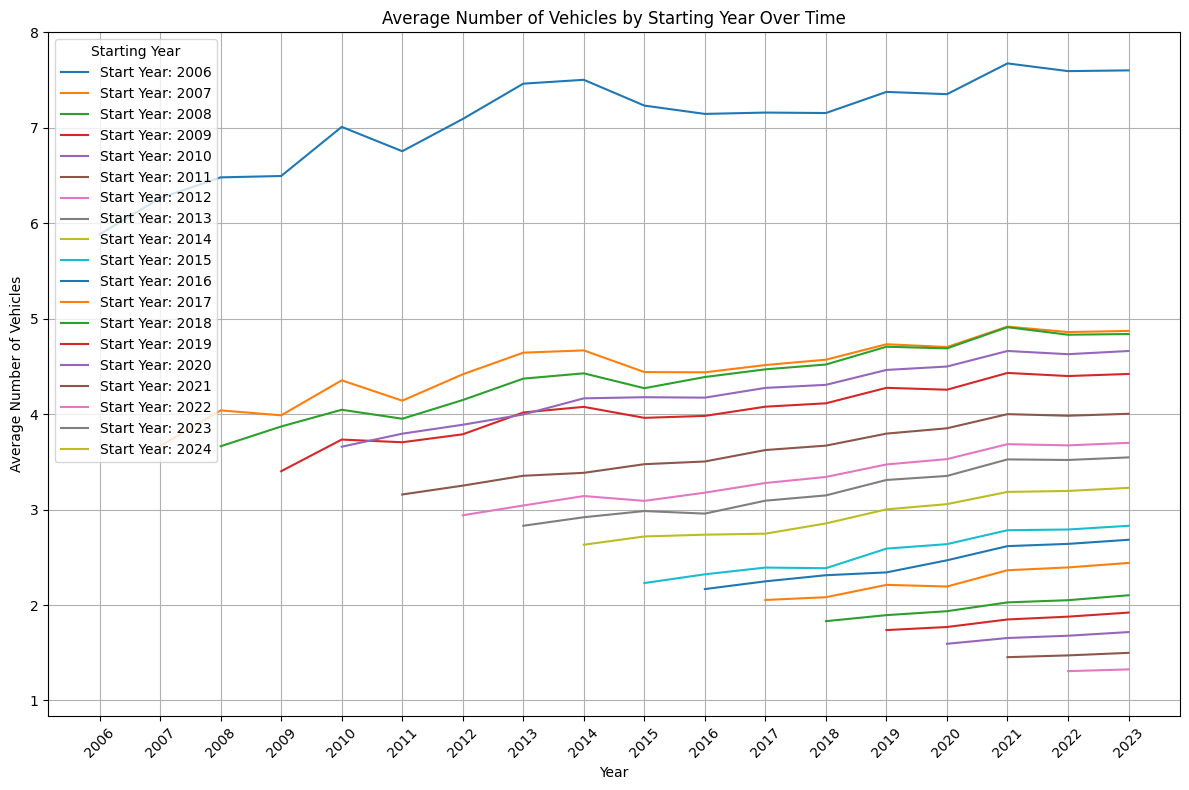

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))  # Set the figure size for better visibility

# Iterate over each column in the transposed DataFrame to create a line plot for each group
for column in transposed_df.columns:
    plt.plot(transposed_df.index, transposed_df[column], label=f'Start Year: {column}')

plt.title('Average Number of Vehicles by Starting Year Over Time')
plt.xlabel('Year')
plt.ylabel('Average Number of Vehicles')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Starting Year', loc='upper left')  # Add a legend to distinguish the lines
plt.grid(True)  # Add grid for easier readability of the plot
plt.tight_layout()  # Adjust layout to make room for x-axis labels

plt.show()


#Create table with individual client data: date joined, % default, and business entity
# DO NOT RUN THIS AGAIN

just use the table later

In [ ]:
df_v=session.sql('select * from CONSOLIDATED_SORTED')
df_v = df_v.select("FECHAEMISION", "BUSINESSPARTNERID","STATUSCOMPENSACION","TIPOCLIENTE","YEAR_FECHAEMISION")

In [ ]:
df_v.show(10)

-----------------------------------------------------------------------------------------------------
|"FECHAEMISION"  |"BUSINESSPARTNERID"  |"STATUSCOMPENSACION"  |"TIPOCLIENTE"  |"YEAR_FECHAEMISION"  |
-----------------------------------------------------------------------------------------------------
|2021-08-26      |0013221790           |UNPAID                |Natural        |2021                 |
|2021-08-26      |0013221790           |UNPAID                |Natural        |2021                 |
|2021-08-26      |0013221790           |UNPAID                |Natural        |2021                 |
|2021-08-26      |0013221790           |UNPAID                |Natural        |2021                 |
|2021-08-26      |0013221790           |UNPAID                |Natural        |2021                 |
|2021-08-26      |0013221790           |UNPAID                |Natural        |2021                 |
|2021-08-26      |0013221790           |PAID                  |Natural        |202

In [ ]:
# Creating DataFrames for each entity type directly in Snowflake
df_natural = df_v.filter(col("TIPOCLIENTE") == "Natural")
df_juridico = df_v.filter(col("TIPOCLIENTE") == "Juridico")

# Function to calculate default rates and first appearance year, then save to Snowflake
def process_and_save(df, entity_type):
    # Calculate default rates
    default_rates_df = df.group_by("BUSINESSPARTNERID", "YEAR_FECHAEMISION").agg(
        (sp_sum(when(col("STATUSCOMPENSACION") == "UNPAID", 1).otherwise(0)) / count("*") * 100).alias("DEFAULT_RATE")
    )

    # Find the first year each client appears
    first_year_df = df.group_by("BUSINESSPARTNERID").agg(
        sp_min("YEAR_FECHAEMISION").alias("FIRST_YEAR")
    )

    # Join default rates with the first year data
    df_joined = default_rates_df.join(
        first_year_df,
        "BUSINESSPARTNERID"
    )

    # Save as a Snowflake table
    table_name = f"USERS_{entity_type}_DEFAULT_RATES"
    df_joined.write.mode('overwrite').save_as_table(table_name)
    print(f"Data for '{entity_type}' entities saved to {table_name}.")


In [ ]:
# Process and save data for 'Natural' entities
process_and_save(df_natural, "NATURAL")

# Process and save data for 'Juridico' entities
process_and_save(df_juridico, "JURIDICO")


Data for 'NATURAL' entities saved to USERS_NATURAL_DEFAULT_RATES.
Data for 'JURIDICO' entities saved to USERS_JURIDICO_DEFAULT_RATES.


# Use tables instead

In [7]:
# Define the table names as strings
table_name_natural = 'USERS_NATURAL_DEFAULT_RATES'
table_name_juridico = 'USERS_JURIDICO_DEFAULT_RATES'

In [8]:
df_natural = session.table(table_name_natural).to_pandas()
df_juridico = session.table(table_name_juridico).to_pandas()


In [9]:
print(df_natural.head(5))
print(df_juridico.head(5))

  BUSINESSPARTNERID  YEAR_FECHAEMISION  DEFAULT_RATE  FIRST_YEAR
0        0011740218               2015           0.0        2011
1        0011740599               2015           0.0        2011
2        0011741607               2015           0.0        2011
3        0011744523               2015           0.0        2012
4        0011744733               2015           0.0        2011
  BUSINESSPARTNERID  YEAR_FECHAEMISION  DEFAULT_RATE  FIRST_YEAR
0        0013765892               2021           0.0        2021
1        0013766058               2021           0.0        2021
2        0013766087               2021           0.0        2021
3        0013766138               2021           0.0        2021
4        0013766659               2021           0.0        2021


In [17]:
# Group and calculate average default rates per year for each start year
grouped_natural = df_natural.groupby(['FIRST_YEAR', 'YEAR_FECHAEMISION']).agg({'DEFAULT_RATE': 'mean'}).reset_index()
grouped_juridico = df_juridico.groupby(['FIRST_YEAR', 'YEAR_FECHAEMISION']).agg({'DEFAULT_RATE': 'mean'}).reset_index()

# Pivot data to format for plotting
pivot_natural = grouped_natural.pivot(index='YEAR_FECHAEMISION', columns='FIRST_YEAR', values='DEFAULT_RATE')
pivot_juridico = grouped_juridico.pivot(index='YEAR_FECHAEMISION', columns='FIRST_YEAR', values='DEFAULT_RATE')


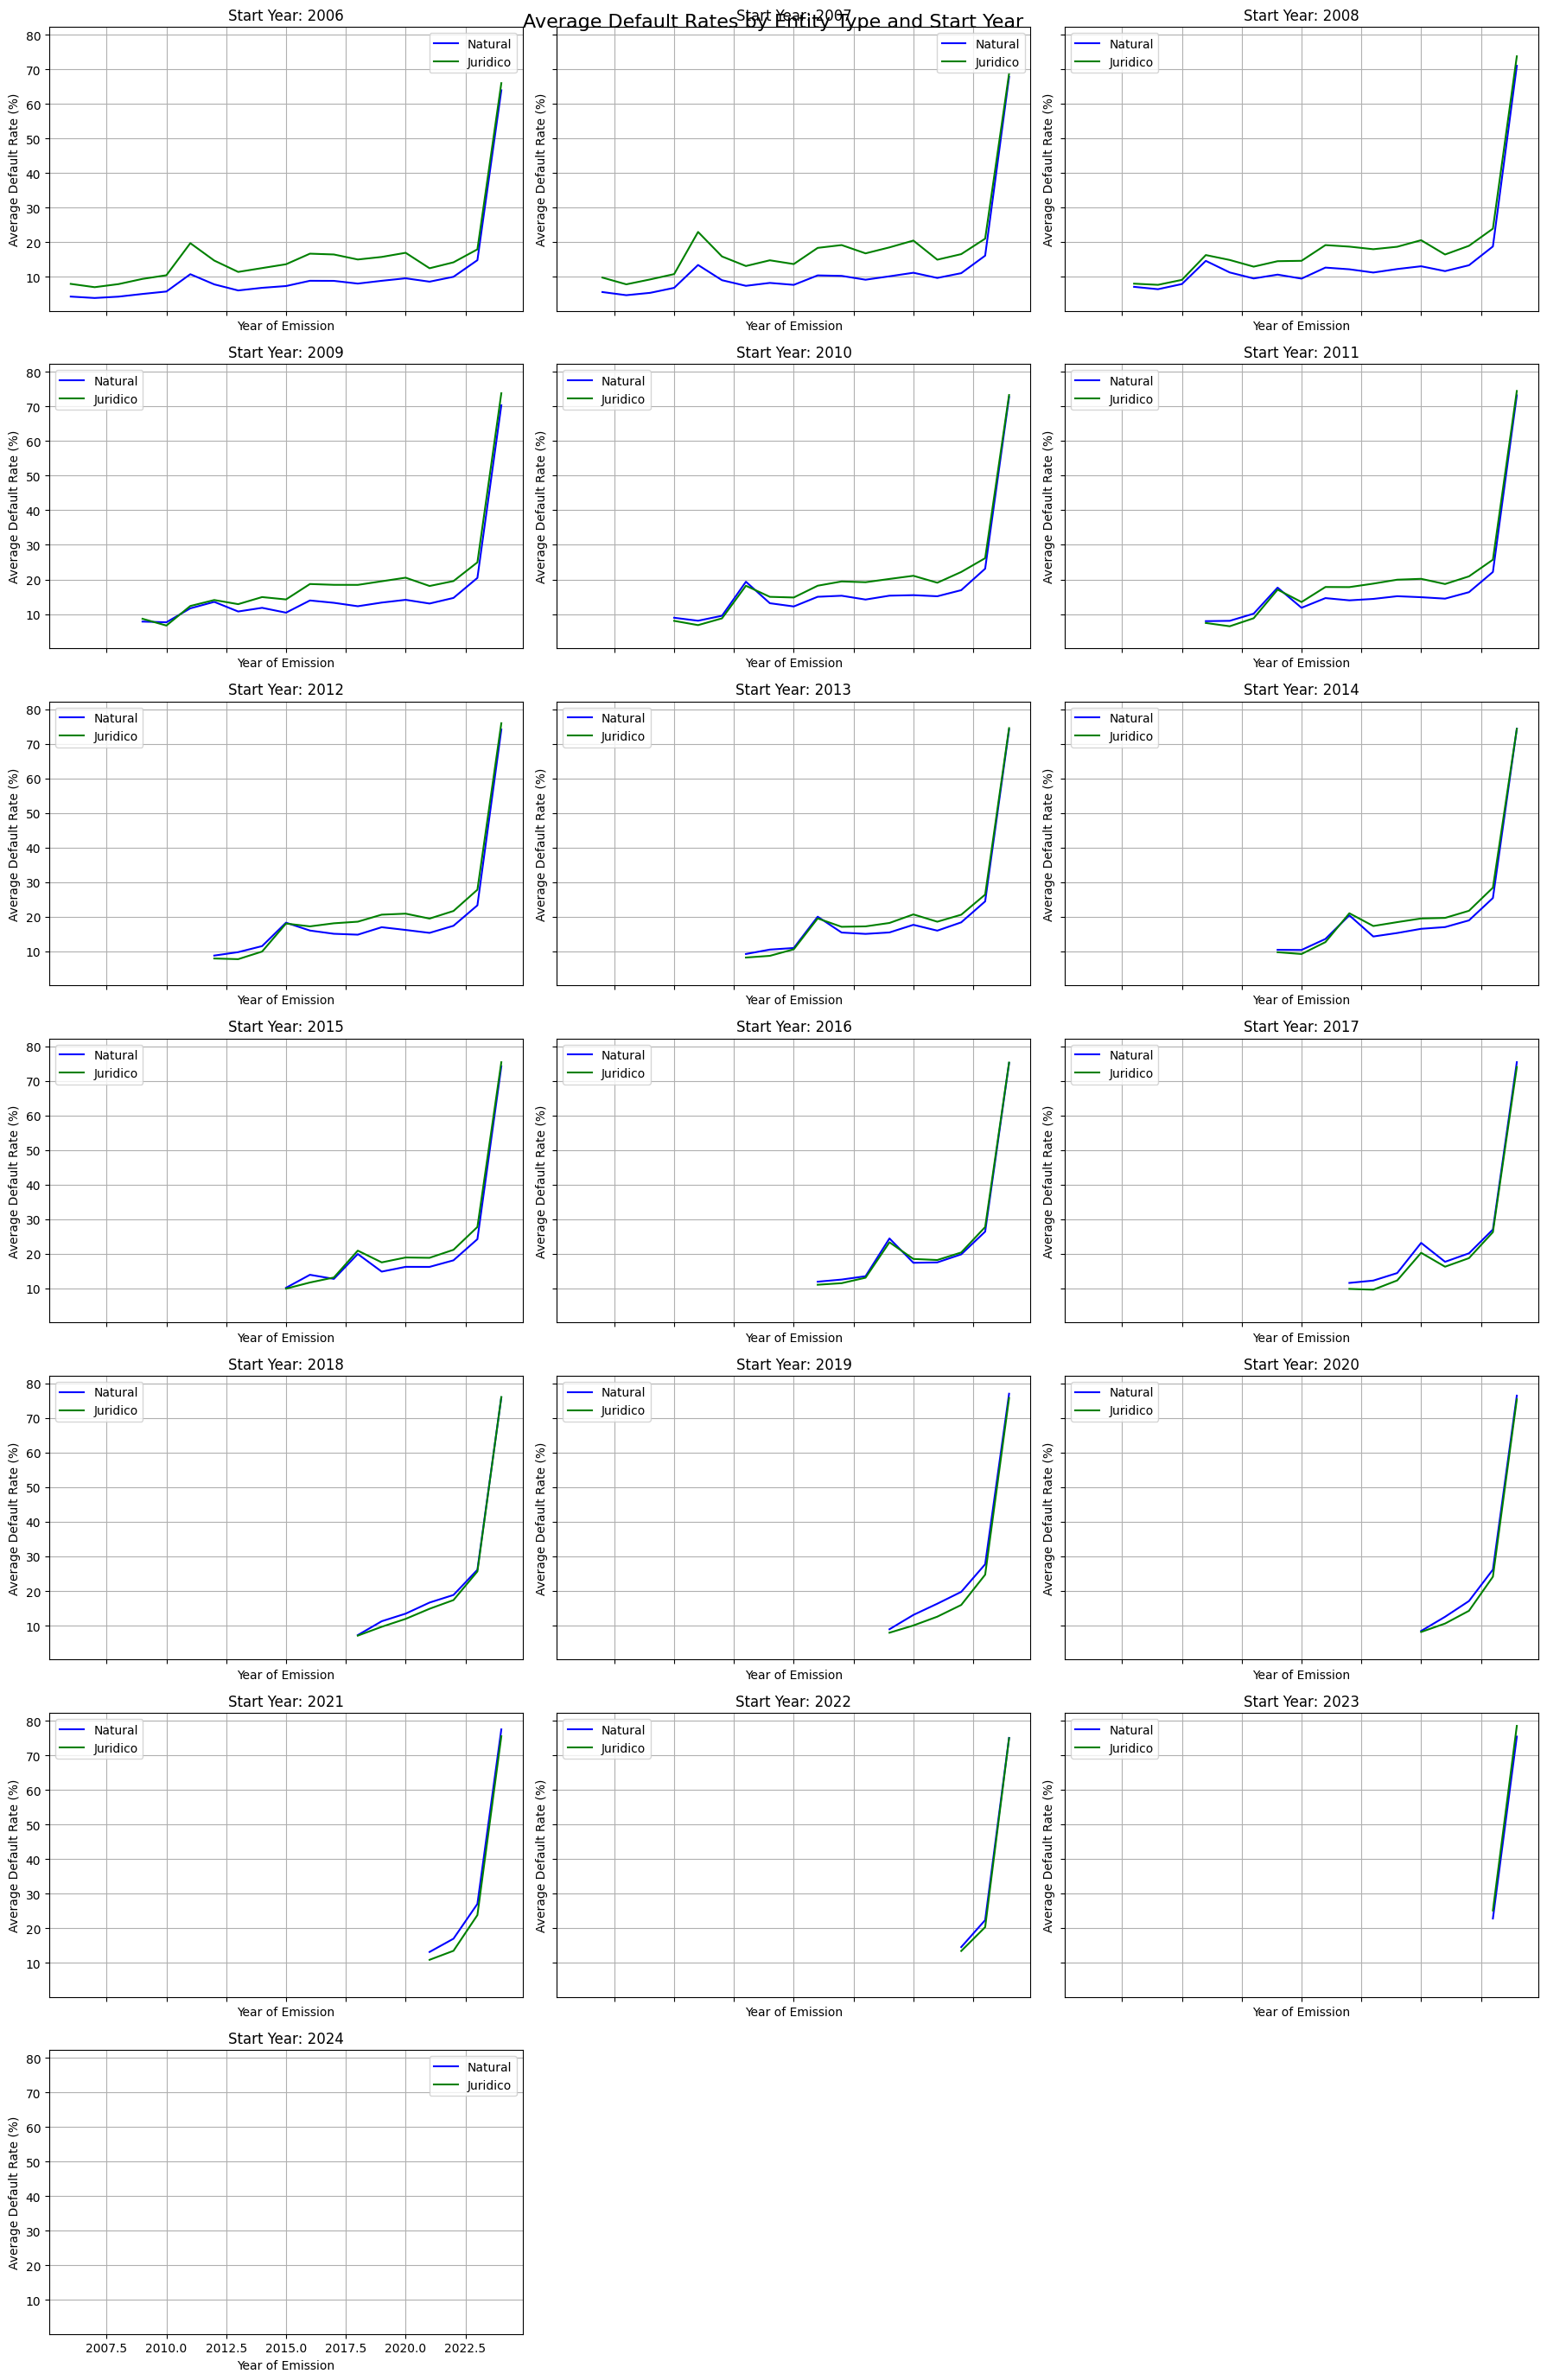

In [20]:
import matplotlib.pyplot as plt

# Define the years for subplots
start_years = sorted(pivot_natural.columns.intersection(pivot_juridico.columns))
total_years = len(start_years)
cols = 3  # Number of columns in subplot grid
rows = total_years // cols + (total_years % cols > 0)  # Calculate rows needed

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows), sharex=True, sharey=True)
fig.suptitle('Average Default Rates by Entity Type and Start Year', fontsize=16)

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot each year's data in its subplot
for i, year in enumerate(start_years):
    ax = axes[i]
    # Plot Natural
    if year in pivot_natural.columns:
        ax.plot(pivot_natural.index, pivot_natural[year], marker='', color='blue', label='Natural')
    # Plot Juridico
    if year in pivot_juridico.columns:
        ax.plot(pivot_juridico.index, pivot_juridico[year], marker='', color='green', label='Juridico')
    ax.set_title(f'Start Year: {year}')
    ax.set_xlabel('Year of Emission')
    ax.set_ylabel('Average Default Rate (%)')
    ax.legend()
    ax.grid(True)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()
